### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [1]:
# libraries
import os
import sys
print(sys.version)

in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Mounted at /content/drive
Installing tensorflow-IO
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 35.8 MB/s eta 0:00:00
Installing keras
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.10.0 which is incompatible.
Installing scikeras
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
installing keras tuner
     ━━━━━━━━━━━━━━━━━━━━━

FileNotFoundError: ignored

# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [9]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

In [4]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = ['1Dim_Conv_AE_raw_flatten_count.txt', 'Dense_AE_ffnn_count.txt', 'AE_Conv_prep_flatten_count.txt', 'Fully_Convolutional_AE_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created 1Dim_Conv_AE_raw_flatten_count.txt with content '0' in folder Saved_Models
Created Dense_AE_ffnn_count.txt with content '0' in folder Saved_Models
Created AE_Conv_prep_flatten_count.txt with content '0' in folder Saved_Models
Created Fully_Convolutional_AE_count.txt with content '0' in folder Saved_Models


## 3.4 Autoencoder on preprocessed audio - Fully Convolutional AE

### Create the dataset

The dataset is not changed from before.

In [ ]:
train, val, test, INPUT_DIM =  create_US_dataset(folder_number=1, preprocessing = 'STFT', main_dir = main_dir)

Create the dataset with 2000 files requires 15.07 seconds.


### Preparation to use Keras-Tuner

This time the convolutional autoencoder builder have a code with more than 1 dimenision.

In [ ]:
#FULLY CONVOLUTIONAL AUTOENCODER

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_channels = 3, # no more than 3 to be able to plot the code
                      activation = 'tanh',
                      n_layers = 2, #no more thank 4
                      n_units = 32,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      ):
    lr = learning_rate

    #check the number of layers
    if n_layers > 4:
        print('The number of layers is too high, it has been set to 4')
        n_layers = 4

    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))

    output_padding_list = []
    lambda_padding_list = []

    for i in range(n_layers):
        filters = n_units * (i+1) if i<n_layers-1 else code_channels
        encoder.add(layers.Conv2D(filters, kernel_size,strides = strides, activation = activation, padding='valid'))

        #save the conv2dtranspose padding for the decoder
        _,width,height,_ = encoder.layers[-1].input_shape
        pad = (width-(((width - kernel_size[0])//strides[0])*strides[0]+kernel_size[0]), height-(((height - kernel_size[1])//strides[1])*strides[1]+kernel_size[1]))
        output_padding_list.append( pad )

        encoder.add(layers.MaxPool2D(max_pooling, padding='valid'))

        #save the upsampling padding for the decoder
        _,width,height,_ = encoder.layers[-1].input_shape
        lambda_padding_list.append((width%max_pooling[0], height%max_pooling[1]))

        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    #check if the code size is reasonable small
    code_prod = np.prod(encoder.layers[-1].output_shape[1:])
    inp_prod = np.prod(INPUT_DIM)
    if code_prod > inp_prod/10:
        print('The input has dimension', np.prod(INPUT_DIM))
        print('The code size (flattened) is', np.prod(encoder.layers[-1].output_shape[1:]))
        print('We must decrease the number of channels at least to ', int(inp_prod/10*code_channels/code_prod))
        return None
    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(shape = encoder.layers[-1].output_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):

        decoder.add(layers.UpSampling2D(size=max_pooling))
        pad = lambda_padding_list[-i-1]
        decoder.add(layers.Lambda(lambda x: tf.pad(x, [[0,0],[0,pad[0]],[0,pad[1]], [0,0]])))

        filters = n_units * (n_layers-i-1) if i<n_layers-1 else img_shape[-1]
        pad =  output_padding_list[-i-1]
        decoder.add(
            layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, output_padding=pad)
        )

        if batch_norm:
            decoder.add(layers.BatchNormalization())
        if drop_out>0:
            decoder.add(layers.Dropout(drop_out))

    #resizing if needed
    if decoder.layers[-1].output_shape[1:] != INPUT_DIM:
        decoder.add(tf.keras.layers.Resizing(height = img_shape[0], width = img_shape[1], interpolation="bilinear", crop_to_aspect_ratio=False))


    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = 'Fully_Convolutional_AE')

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [ ]:
verbose = 2
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 2, strides = (1,1), max_pooling = (2,2), code_channels = 1)
if verbose > 1 and autoencoder is not None:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)

Model built with 1350 trainable params
Model: "Fully_convolutional_autoencoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_66 (InputLayer)                       [(None, 64, 128, 1)]                    0              
                                                                                                    
 Encoder (Sequential)                        (None, 14, 30, 1)                       741            
                                                                                                    
 Decoder (Sequential)                        (None, 64, 128, 1)                      741            
                                                                                                    
Total params: 1,482
Trainable params: 1,350
Non-trainable params: 132
__________________________________________

In [ ]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp):

    n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
    n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 4, step=1, sampling='linear', default = 2)
    kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
    strides = hp.Choice(name = 'strides', values = [1,2,3], default = 2)
    max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3,4], default = 2)
    code_channels= hp.Int(name = 'code_channels', min_value = 1, max_value = 6, step = 1, sampling = 'linear', default = 3)
    activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
    drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
    batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
    learning_rate= hp.Float('learning_rate', min_value=1e-4, max_value = 1e-1, sampling='log')


    model = build_autoencoder(code_channels = code_channels,
                              activation = activation,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [ ]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 2508 trainable params
Model: "Fully_convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 3, 7, 3)           1327      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        1317      
                                                                 
Total params: 2,644
Trainable params: 2,508
Non-trainable params: 136
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [ ]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 3,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'code_channels':300,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
max_model_size = 10**7
max_trials = 10
dir_name = 'Fully_Convolutional_AE'
verbose=1

#define a smaller dataset for the grid search
small_size_dataset = 40 #increase this up to 2000 for a better grid search
train_val_small = train.unbatch().take(small_size_dataset)
train_small = train_val_small.skip(10).batch(25)
val_small = train_val_small.take(10).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}


for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        #create a tuner for the params not fixed
        tuner = build_tuner(build_model = build_model,
                            hpo_method = hpo_method,
                            max_model_size = max_model_size,
                            max_trials = max_trials,
                            dir_name = dir_name,
                            overwrite = True,
                            objective = kt.Objective('val_mse', direction='min'),
                            hp=hp,
                            not_fixed_param = hyper_params,
                            tune_new_entries=True
                            )

        print(type(tuner))

        if verbose>2:
            display(tuner.search_space_summary(extended = True))

        #fit the tuner
        epochs = 1 ### CAMBIARE A 50 !!!!!!!!
        patience = 20
        metrics = ['mse']
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                    verbose=verbose,
                                                    patience=patience)]

        try:
            tuner.search(train_small, validation_data = val_small,
                                callbacks=callbacks,
                                epochs=epochs,
                                verbose=int(verbose>0),
                        )

            #retrive the best value for the free hp
            best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

            #retrive the best score reached
            best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']
            #The models are loaded with the weights corresponding to their best checkpoint (at the end of the best epoch of best trial).
            #altrernatively
            #best_score = tuner.load_model(tuner.oracle.get_best_trials(num_trials=1)[0]).evaluate(val, return_dict=True)['mse']

            print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
            best_score_dict[hpo_method].append(best_score)

            #update the default dict of values
            default_values[hyper_params] = best_value

            #save the updated dictionary
            file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
            with open(file_path, 'wb') as file:
                pickle.dump(default_values, file)

        except:
            print('The model has a code too big, we skip this trial')

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores')
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)



Trial 1 Complete [00h 00m 12s]
val_mse: 0.0871329978108406

Best val_mse So Far: 0.0871329978108406
Total elapsed time: 00h 00m 12s
The model  has a code too big, we skip this trial
Searching for the best value for code_channels
Using Bayesian Optimization strategy for HPO



KeyboardInterrupt



In [ ]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,code_channels,activation,drop_out,batch_norm,learning_rate
RandomSearch,2,64,3,2,2,128,tanh,0.5,1,0.030305
BayesianOptimization,1,16,3,1,2,1,elu,0.5,1,0.030305
Hyperband,1,16,3,1,2,8,elu,0.0,0,0.036604


### Train the model with best params on more data

Model built with 3235 trainable params
Model: "Fully_convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 10, 20, 32)        1728      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        1573      
                                                                 
Total params: 3,301
Trainable params: 3,235
Non-trainable params: 66
_________________________________________________________________
Create the dataset with 2000 files requires 0.57 seconds.


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Fully_Convolutional_AE\assets


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Fully_Convolutional_AE\assets


Best epoch: 1


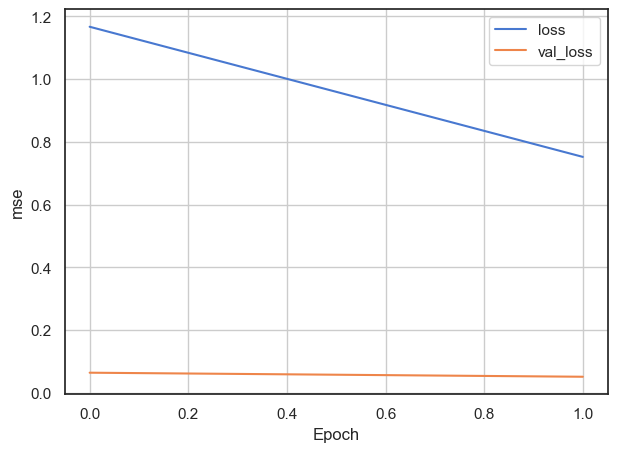

2/2 [==============================] - 0s 80ms/step - loss: 0.0524 - mse: 0.0524


[0.05242084339261055, 0.05242084339261055]

0.0780792236328125 MB
1/1 [==============================] - 0s 200ms/step


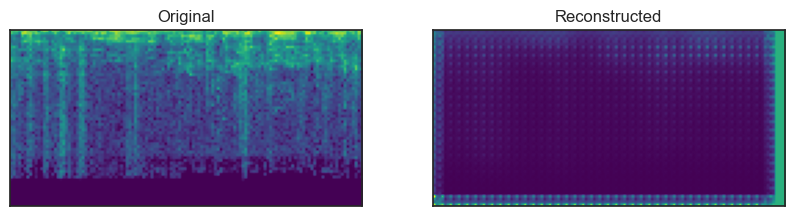

In [ ]:
best_params = {
    'n_layers':1,
    'n_units':16,
    'kernel_size':(7,7),
    'strides':(3,3),
    'max_pooling':(2,2),
    'code_channels':32,
    'activation':'elu',
    'drop_out':0,
    'batch_norm':True,
    'learning_rate':0.0116,
}

# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

US_training(AE_name = 'Fully_Convolutional_AE', autoencoder = autoencoder, epochs = 1 , n_folders=2)

### Show the reconstruction capabilities of the model

In [ ]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models','Fully_Convolutional_AE'))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Since there's less variability in the audio from unlabelled dataset we evaluate the autoencoder reconstruction on the labelled dataset.

Model: "Fully_convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 10, 20, 32)        1728      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        1573      
                                                                 
Total params: 3,301
Trainable params: 3,235
Non-trainable params: 66
_________________________________________________________________
1/1 [==============================] - 0s 65ms/step


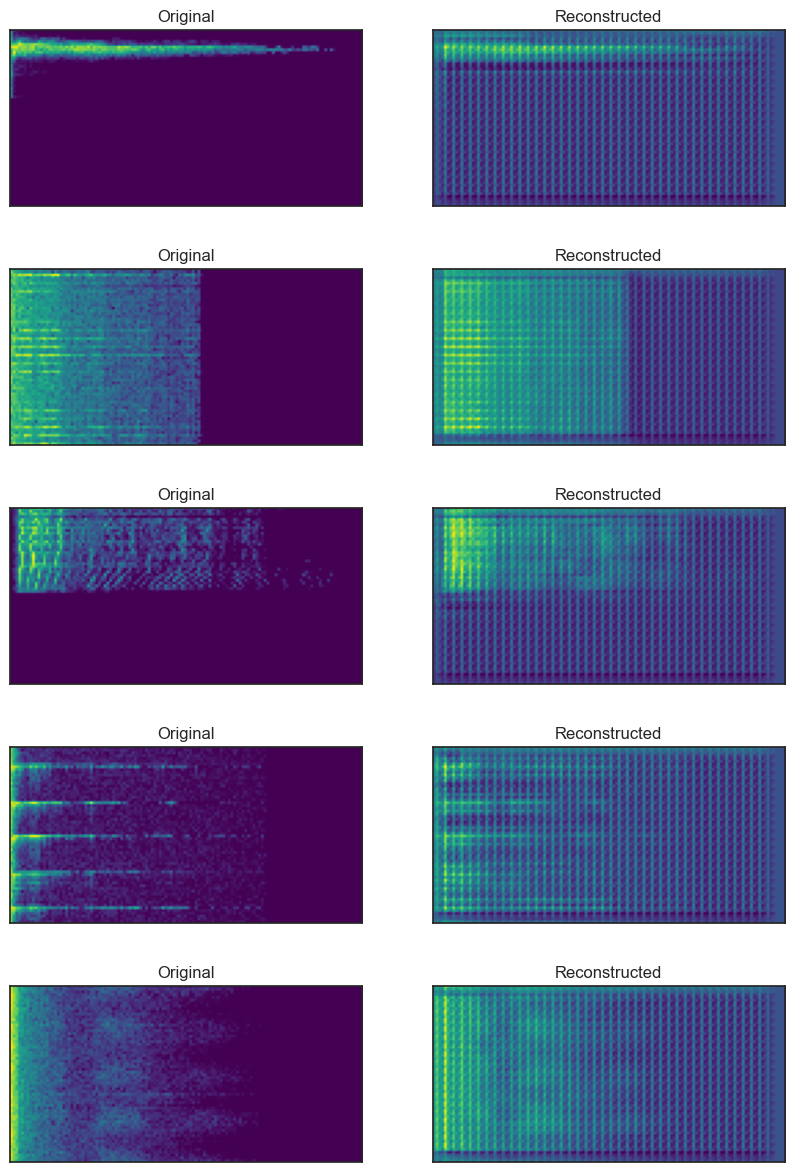

In [ ]:

train, val, test, label_names, INPUT_DIM, n_labels = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = 'STFT',   # "STFT", "MEL", "MFCC" or None
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models','Fully_Convolutional_AE'))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = loaded_model, n_figures = 5, test=test)